# Reto | Generación de un modelo inteligente de clasificación con redes neuronales profundas para la detección de amenazas aéreas

**Objetivos**:
El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos:

- Preparar una base de datos y generar los conjuntos de entrenamiento y prueba.
- Diseñar un modelo utilizando una red neuronal convolucional desde cero y determinar sus hiperparámetros.
- Diseñar un modelo utilizando una red neuronal convolucional utilizando un modelo pre-entrenado.
- Generar un modelo utilizando la herramienta Teachable Machine.
- Validar, evaluar y comparar los tres diferentes modelos generados y seleccionar el mejor considerando la exactitud como indicador de desempeño.
- Exportar los modelos generados para poder utilizarlos dentro de Colab o algún otro sitio.

## 1. Preprocesamiento de la base de datos

In [1]:
# Montando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Eliminando cualquiero archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto/datos/objetos -type f ! -name "*.jpg" ! -name "*.jpeg" ! -name "*.png" -delete


In [4]:
# Directorio base
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
dir_base = pathlib.Path(dir_base)
conteo_img = len(list(dir_base.glob('*/*')))
print('El total de imágenes es de:',conteo_img)


El total de imágenes es de: 8218


In [ ]:
# Correr si hay error al momento de entrenar el primer modelo
# for img_path in dir_base.rglob('*.[jp][pn]g'):
#     try:
#         img = tf.io.read_file(str(img_path))
#         img = tf.image.decode_image(img,channels=3)
#     except:
#         print('Error al decodificar:',img_path)
#         os.remove(img_path)

In [5]:
# Imágenes por clase
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
class_names = sorted(os.listdir(dir_base))

counts = {name: len(os.listdir(os.path.join(dir_base,name))) for name in class_names}
for clase,num in counts.items():
  print(f'La clase {clase} tiene {num} imágenes')

La clase avion tiene 1397 imágenes
La clase cohete tiene 1136 imágenes
La clase dron tiene 1290 imágenes
La clase helicoptero tiene 1328 imágenes
La clase jet tiene 1801 imágenes
La clase misil tiene 1266 imágenes


In [6]:
# Peso de las clases para balancear
total_muestras = 8218
class_weights = {
    0 : total_muestras / (6*counts['avion']), # Avion
    1 : total_muestras / (6*counts['cohete']), # Cohete
    2 : total_muestras / (6*counts['dron']), # Dron
    3 : total_muestras / (6*counts['helicoptero']), # Helicoptero
    4 : total_muestras / (6*counts['jet']), # Jet
    5 : total_muestras / (6*counts['misil']) # Misil
}

for clase, peso in class_weights.items():
  print(f'La clase {clase} tiene un peso de {peso:.4f}')

La clase 0 tiene un peso de 0.9804
La clase 1 tiene un peso de 1.2057
La clase 2 tiene un peso de 1.0618
La clase 3 tiene un peso de 1.0314
La clase 4 tiene un peso de 0.7605
La clase 5 tiene un peso de 1.0819


## 2. Generación de conjuntos de entrenamiento, prueba y aumentación de datos

In [7]:
# Tamaño de las imágenes y lote
alto_img = 128
ancho_img = 128
tam_lote = 32

Para la creación de los conjuntos de entrenamiento y prueba se usará la función:

```
image_dataset_from_directory
```



In [9]:
# Definición del conjunto de entrenamiento
conj_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

# Definición del conjunto de prueba
conj_prueba = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)
# Prefetch y Cache
conj_entrenamiento = conj_entrenamiento.cache().shuffle(1000).prefetch(
    buffer_size=tf.data.AUTOTUNE)
conj_prueba = conj_prueba.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 8218 files belonging to 6 classes.
Using 6575 files for training.
Found 8218 files belonging to 6 classes.
Using 1643 files for validation.


## 3. Diseña una arquitectura de una red neuronal convolucional profunda desde cero para resolver el problema de clasificación


In [ ]:
from tensorflow.keras import regularizers
# Definición del primer modelo
redConv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(alto_img,ancho_img,3)),
    tf.keras.layers.Rescaling(1/255),

    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.08),
    tf.keras.layers.RandomTranslation(0.08,0.08),

    # Convoluciones
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(6,activation='softmax')
])
redConv.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_5               │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 489,798 (1.87 MB)

 Trainable params: 488,838 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compilación del modelo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=1e-4)

redConv.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# LR
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

## 4. Diseña una arquitectura de una red neuronal convolucional profunda que utilice como base un modelo pre-entrenado para resolver el problema de clasificación

Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.



In [10]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.08),
    tf.keras.layers.RandomBrightness(0.08),
    tf.keras.layers.RandomTranslation(0.04, 0.04),
])

#### 4.1 Modelo MobileNetV2
Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.


In [11]:

# Configurar modelo pre-entrenado
forma_img = (128,128,3)
modelo_base = tf.keras.applications.MobileNetV2(
    input_shape = forma_img,
    include_top = False,
    weights='imagenet'
)
modelo_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Es importante normalizar los datos de entrada en la base convolucional.

In [12]:
from tensorflow.keras import regularizers
# Modelo completo
inputs = tf.keras.Input(shape=forma_img)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
modelo_pre = tf.keras.Model(inputs, outputs)
modelo_pre.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4.2 Modelo Preentreado EfficientNetB0

In [13]:
modelo_base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3)
)

modelo_base.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
from tensorflow.keras import regularizers
# Modelo Completo
inputs = tf.keras.Input(shape=(128,128,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(6,activation='softmax')(x)
modelo_completo = tf.keras.Model(inputs,outputs)
modelo_completo.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compilación del modelo
opt = Adam(learning_rate=1e-4)
modelo_completo.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
# Reducir Learning Rate
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

## 5. Modelo con Teachable Machine
Para la generación del modelo en Teachable Machine se declararán 6 clases:
1. Misil
2. Jet
3. Helicóptero
4. Dron
5. Cohete
6. Avión

Para la creación del modelo se eligirán las primeras 200 imágenes de cada clase.

Los hiperparámetros serán los siguientes:

- Épocas: 50
- Tamaño del lote: 32
- Tasa de aprendizaje : 0.001

## 6. Entrena y ajusta las arquitecturas diseñadas

### 6.1 Primer Modelo

In [ ]:
# Entrenamiento del modelo
evolucion = redConv.fit(
    conj_entrenamiento,
    validation_data = conj_prueba,
    epochs = 50,
    callbacks = [early_stopping,reduce_lr],
    class_weight = class_weights
 )

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.1932 - loss: 2.0657 - val_accuracy: 0.1284 - val_loss: 2.0222 - learning_rate: 1.0000e-04
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2301 - loss: 1.8121 - val_accuracy: 0.1759 - val_loss: 1.9152 - learning_rate: 1.0000e-04
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2627 - loss: 1.7663 - val_accuracy: 0.2824 - val_loss: 1.7264 - learning_rate: 1.0000e-04
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2820 - loss: 1.7389 - val_accuracy: 0.2788 - val_loss: 1.7087 - learning_rate: 1.0000e-04
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2976 - loss: 1.7238 - val_accuracy: 0.2921 - val_loss: 1.6956 - learning_rate: 1.0000e-04
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.3028 - loss: 1.7044 - val_accuracy: 0.3104 - val_loss: 1.6756 - learning_rate: 1.0000e-04
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/ste

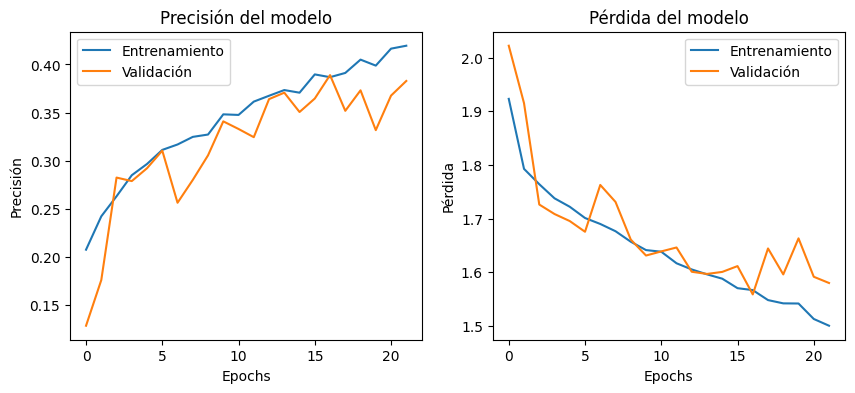

In [ ]:
# Gráfico de la evolución de entrenamiento y pérdida
# Historial de entrenamiento
hist = evolucion.history
plt.figure(figsize=(10,4))

# Presición del modelo
plt.subplot(1,2,1)
plt.plot(hist['accuracy'],label='Entrenamiento')
plt.plot(hist['val_accuracy'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()

# Pérdida del modelo
plt.subplot(1,2,2)
plt.plot(hist['loss'],label='Entrenamiento')
plt.plot(hist['val_loss'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.title('Pérdida del modelo')
plt.legend()

plt.show()

### 6.2 Modelo Preentrenado MobileNetV2

In [16]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True,
)
# Reducir Learning Rate
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

# Compilar modelo final
modelo_pre.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)


Se entrenará el clasificador con el modelo base congelado, posteriormente, se hará fine-tuning, descongelando las últimas capas de MobileNetV2 para obtener mejores resultados.

In [18]:
# Entrenamiento
print('Fase 1: Base Congelada')
historial_1 = modelo_pre.fit(
    conj_entrenamiento,
    epochs=15,
    validation_data = conj_prueba,
    callbacks = [early_stopping,lr],
    class_weight = class_weights
)

Fase 1: Base Congelada
Epoch 1/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 2761s 3s/step - accuracy: 0.2740 - loss: 1.8340 - val_accuracy: 0.4985 - val_loss: 1.3391 - learning_rate: 1.0000e-04
Epoch 2/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 152s 737ms/step - accuracy: 0.4572 - loss: 1.3790 - val_accuracy: 0.5526 - val_loss: 1.2081 - learning_rate: 1.0000e-04
Epoch 3/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 198s 722ms/step - accuracy: 0.5234 - loss: 1.2182 - val_accuracy: 0.5758 - val_loss: 1.1505 - learning_rate: 1.0000e-04
Epoch 4/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 146s 708ms/step - accuracy: 0.5193 - loss: 1.1943 - val_accuracy: 0.5898 - val_loss: 1.1041 - learning_rate: 1.0000e-04
Epoch 5/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 210s 747ms/step - accuracy: 0.5586 - loss: 1.1321 - val_accuracy: 0.6032 - val_loss: 1.0700 - learning_rate: 1.0000e-04
Epoch 6/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 145s 703ms/step - accuracy: 0.5874 - loss: 1.0937 - val_accuracy: 0.6141 - val_loss: 1.0489 - learning_rate: 1.0000e-04
Epoch 7/15
206/206 

In [20]:
print('Fase 2: Fine-Tuning')

# Fine-Tuning
modelo_base.trainable = True

# Se entrenarán las últimas 30 capas
for layer in modelo_base.layers[:-30]:
    layer.trainable = False

# Compilación del modelo
modelo_pre.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-6,weight_decay=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
# Entrenamiento
historia_2 = modelo_pre.fit(
    conj_entrenamiento,
    epochs=30,
    validation_data = conj_prueba,
    callbacks = [early_stopping,lr]
)

Fase 2: Fine-Tuning
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 157s 724ms/step - accuracy: 0.6600 - loss: 0.9245 - val_accuracy: 0.6324 - val_loss: 0.9856 - learning_rate: 5.0000e-06
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 197s 702ms/step - accuracy: 0.6672 - loss: 0.8958 - val_accuracy: 0.6342 - val_loss: 0.9883 - learning_rate: 5.0000e-06
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 146s 707ms/step - accuracy: 0.6663 - loss: 0.8880 - val_accuracy: 0.6318 - val_loss: 0.9877 - learning_rate: 5.0000e-06
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 205s 723ms/step - accuracy: 0.6636 - loss: 0.9008 - val_accuracy: 0.6324 - val_loss: 0.9879 - learning_rate: 5.0000e-06
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 145s 705ms/step - accuracy: 0.6691 - loss: 0.8879 - val_accuracy: 0.6312 - val_loss: 0.9873 - learning_rate: 5.0000e-06
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 149s 724ms/step - accuracy: 0.6584 - loss: 0.8957 - val_accuracy: 0.6306 - val_loss: 0.9882 - learning_rate: 5.0000e-06
Epoch 7/30
206/206 ━

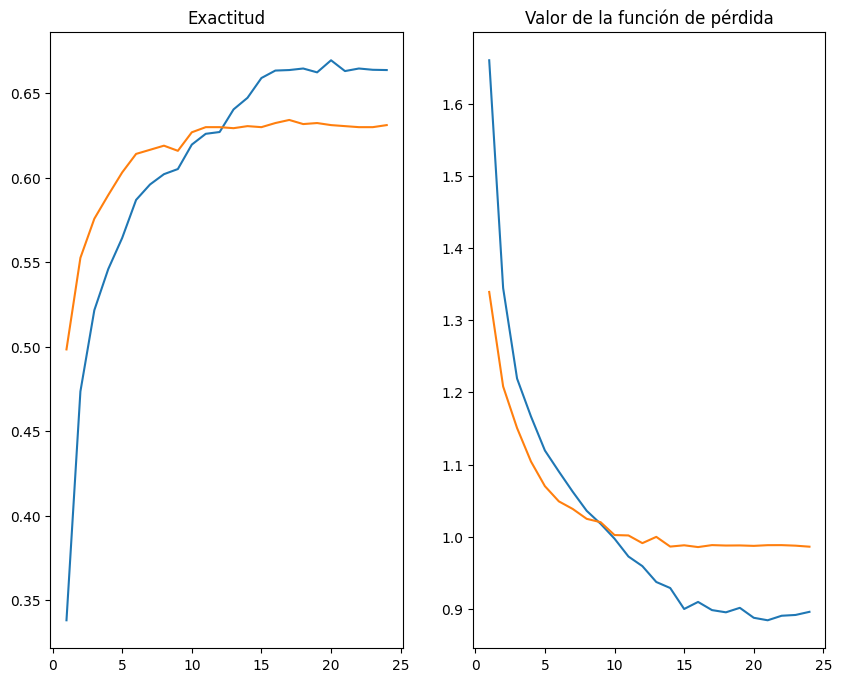

In [21]:
# Combinando historiales
acc = historial_1.history['accuracy'] + historia_2.history['accuracy']
val_acc = historial_1.history['val_accuracy'] + historia_2.history['val_accuracy']

loss = historial_1.history['loss'] + historia_2.history['loss']
val_loss = historial_1.history['val_loss'] + historia_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='Exactitud Entrenamiento')
plt.plot(epochs,val_acc,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(epochs,loss,label='Perdida Entrenamiento')
plt.plot(epochs,val_loss,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()

### 6.3 Modelo Preentrenado EfficientNetB0

In [24]:
# Entrenamiento
historial_1 = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_prueba,
    epochs=15,
    callbacks=[early_stopping,lr],
    class_weight = class_weights
)

Epoch 1/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.3036 - loss: 1.6905 - val_accuracy: 0.6001 - val_loss: 1.0919 - learning_rate: 1.0000e-04
Epoch 2/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.5568 - loss: 1.1685 - val_accuracy: 0.6214 - val_loss: 0.9977 - learning_rate: 1.0000e-04
Epoch 3/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.6075 - loss: 1.0237 - val_accuracy: 0.6336 - val_loss: 0.9423 - learning_rate: 1.0000e-04
Epoch 4/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.6453 - loss: 0.9366 - val_accuracy: 0.6519 - val_loss: 0.9123 - learning_rate: 1.0000e-04
Epoch 5/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.6641 - loss: 0.8816 - val_accuracy: 0.6586 - val_loss: 0.8994 - learning_rate: 1.0000e-04
Epoch 6/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6967 - loss: 0.7942 - val_accuracy: 0.6567 - val_loss: 0.8929 - learning_rate: 1.0000e-04
Epoch 7/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - acc

In [26]:
# Fine- Tuning
modelo_base.trainable = True
for layer in modelo_base.layers[:-25]:
    layer.trainable = False

# Compilación del modelo
modelo_completo.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='max'
)
# Reducir Learning Rate
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)
# Entrenamiento
historia_2 = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_prueba,
    epochs=30,
    callbacks=[early_stopping,lr],
    class_weight = class_weights
)

Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7368 - loss: 0.7045 - val_accuracy: 0.6677 - val_loss: 0.8756 - learning_rate: 1.0000e-05
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7406 - loss: 0.7013 - val_accuracy: 0.6665 - val_loss: 0.8759 - learning_rate: 1.0000e-05
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.7361 - loss: 0.6980 - val_accuracy: 0.6689 - val_loss: 0.8739 - learning_rate: 1.0000e-05
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7383 - loss: 0.6851 - val_accuracy: 0.6689 - val_loss: 0.8742 - learning_rate: 1.0000e-05
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7477 - loss: 0.6857 - val_accuracy: 0.6659 - val_loss: 0.8738 - learning_rate: 1.0000e-05
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7388 - loss: 0.6900 - val_accuracy: 0.6646 - val_loss: 0.8731 - learning_rate: 1.0000e-05
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - acc

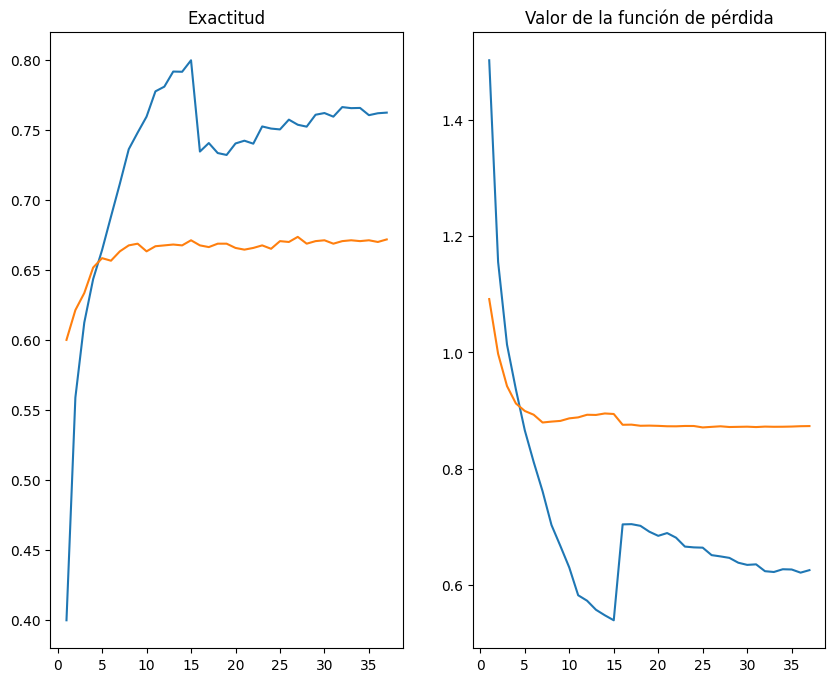

In [27]:
# Combinando historiales
acc = historial_1.history['accuracy'] + historia_2.history['accuracy']
val_acc = historial_1.history['val_accuracy'] + historia_2.history['val_accuracy']

loss = historial_1.history['loss'] + historia_2.history['loss']
val_loss = historial_1.history['val_loss'] + historia_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='Exactitud Entrenamiento')
plt.plot(epochs,val_acc,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(epochs,loss,label='Perdida Entrenamiento')
plt.plot(epochs,val_loss,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()
plt.show()

### 6.4 Modelo de Teachable Machine

In [ ]:
from keras import layers, Sequential
from PIL import Image, ImageOps
import numpy as np

# Definiendo ruta
ruta_modelo = '/content/drive/MyDrive/Reto/model.savedmodel1'

# Cargando modelo
modelo_tm = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    tf.keras.layers.TFSMLayer(ruta_modelo,call_endpoint='serving_default')
])

# Compilando el modelo
modelo_tm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## 7. Exportación de Modelos

### 7.1 Primer Modelo

In [ ]:
# Guardar modelo
redConv.save('/content/drive/MyDrive/Reto/modelo_redConv.keras')


In [30]:
# Cargar modelo
modelo_redConv = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_redConv.keras')

### 7.2 Modelo pre-entrenado MobileNetV2

In [22]:
# Guardar modelo
modelo_pre.save('/content/drive/MyDrive/Reto/modelo_pre.keras')

In [23]:
# Cargar modelo
modelo_prentrenado = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_pre.keras')

### 7.3 Modelo preentrenado EfficientNetB0

In [28]:
# Guardar modelo
modelo_completo.save('/content/drive/MyDrive/Reto/modelo_completoB0.keras')


In [29]:
# Cargar modelo
modelo_prentrenado_B0 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_completoB0.keras')

### 7.4 Modelo de Teachable Machine

In [ ]:
# Cargar modelo
modelo_tm.save('/content/drive/MyDrive/Reto/modelo_TM.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 320 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Cargar modelo
modelo_TM = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_TM.keras')

## 8. Comparativa de los tres modelos generados en el problema de clasificación

### 8.1 Evaluación del Primer Modelo

In [31]:
# Pérdida y Exactitud
loss_redConv, acc_redConv = modelo_redConv.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_redConv:.4f}')
print(f' Exactitud del modelo: {acc_redConv:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 438ms/step - accuracy: 0.3567 - loss: 1.5875
 Pérdida del modelo: 1.5589
 Exactitud del modelo: 0.3889


### 8. 2 Evaluación del Modelo Preentrenado MobileNetV2

In [32]:
loss_pre, acc_pre = modelo_prentrenado.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_pre:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_pre:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 421ms/step - accuracy: 0.6152 - loss: 1.0163
 Pérdida del modelo pre-entrenado: 0.9856
 Exactitud del modelo pre-entrenado: 0.6324


### 8. 3 Evaluación del Modelo Preentrenado EfficientNetB0

In [33]:
loss_eff, acc_eff = modelo_prentrenado_B0.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_eff:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_eff:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 47s 772ms/step - accuracy: 0.6600 - loss: 0.9137
 Pérdida del modelo pre-entrenado: 0.8730
 Exactitud del modelo pre-entrenado: 0.6738


### 8.4 Evaluación del modelo de Teachable Machine

In [ ]:
# Pérdida y Exactitud
loss_tm, acc_tm = modelo_tm.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_tm:.4f}')
print(f' Exactitud del modelo: {acc_tm:.4f}')

NameError: name 'modelo_tm' is not defined

### 7.4 Comparación de los tres modelos

#### 7.4.1 Comparación de exactitudes

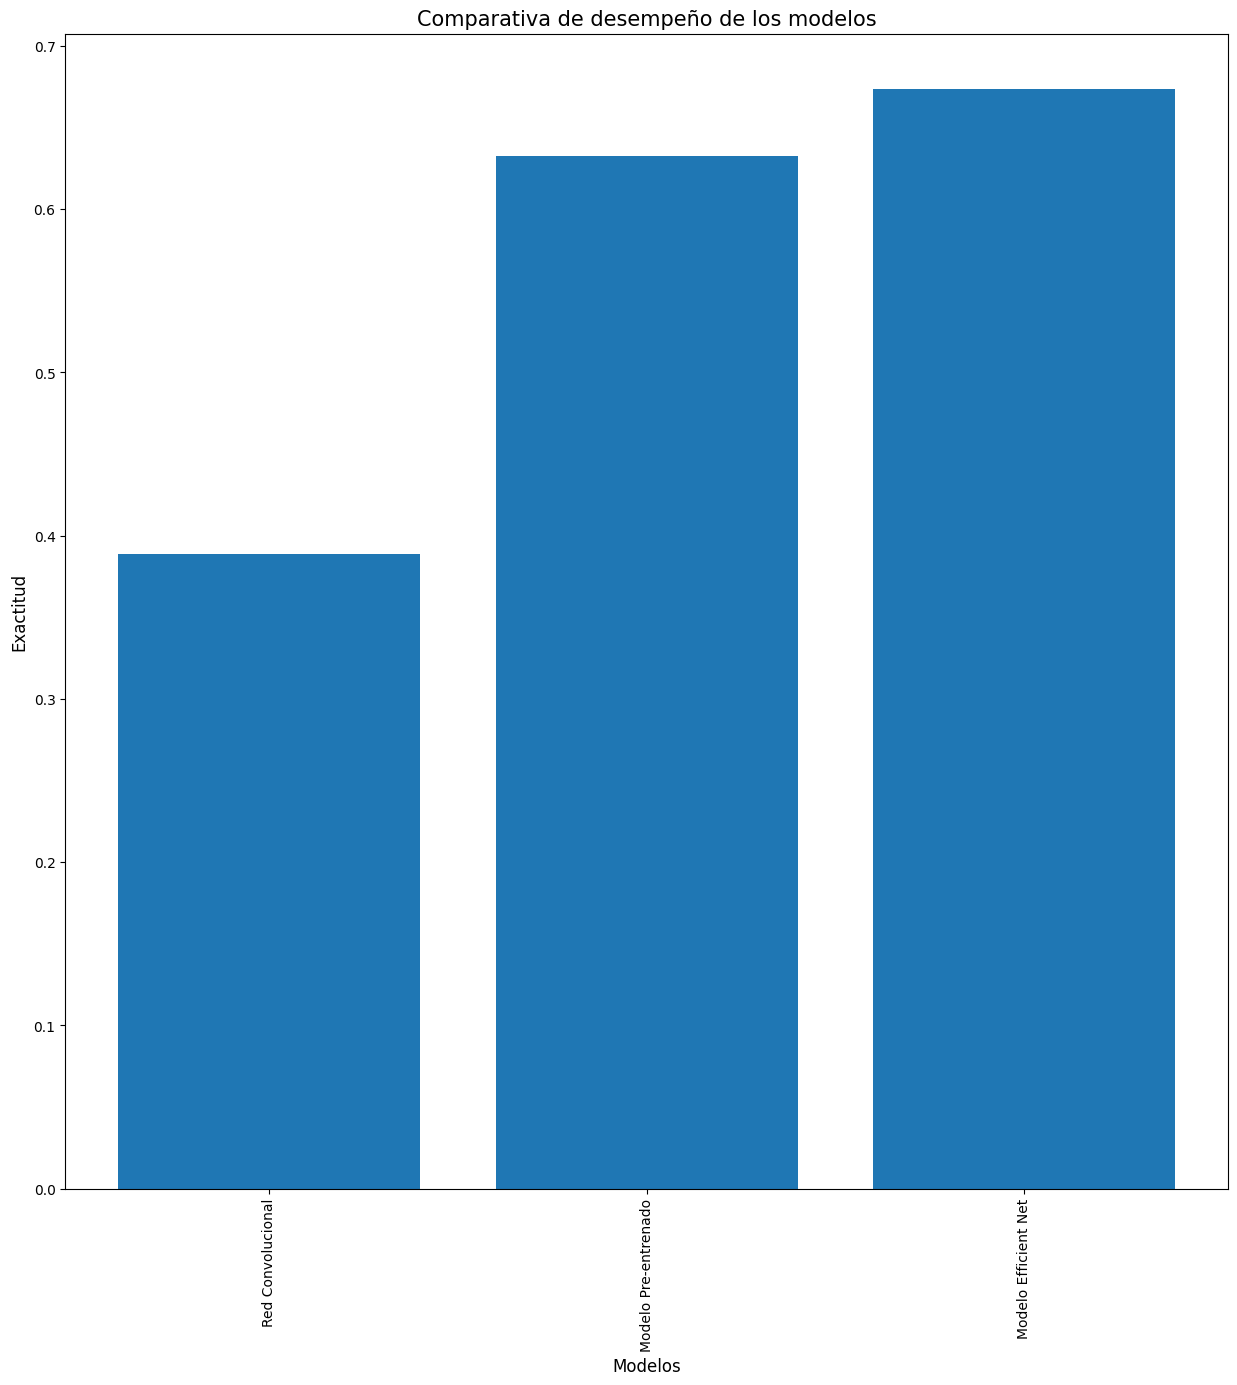

In [34]:
exactitudes = [acc_redConv,acc_pre,acc_eff]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Efficient Net']
plt.figure(figsize=(15,15))
plt.bar(modelos,exactitudes)
plt.xlabel('Modelos',fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Exactitud',fontsize=12)
plt.title('Comparativa de desempeño de los modelos',fontsize=15)
plt.show()

#### 7.4.2 Comparación de pérdidas

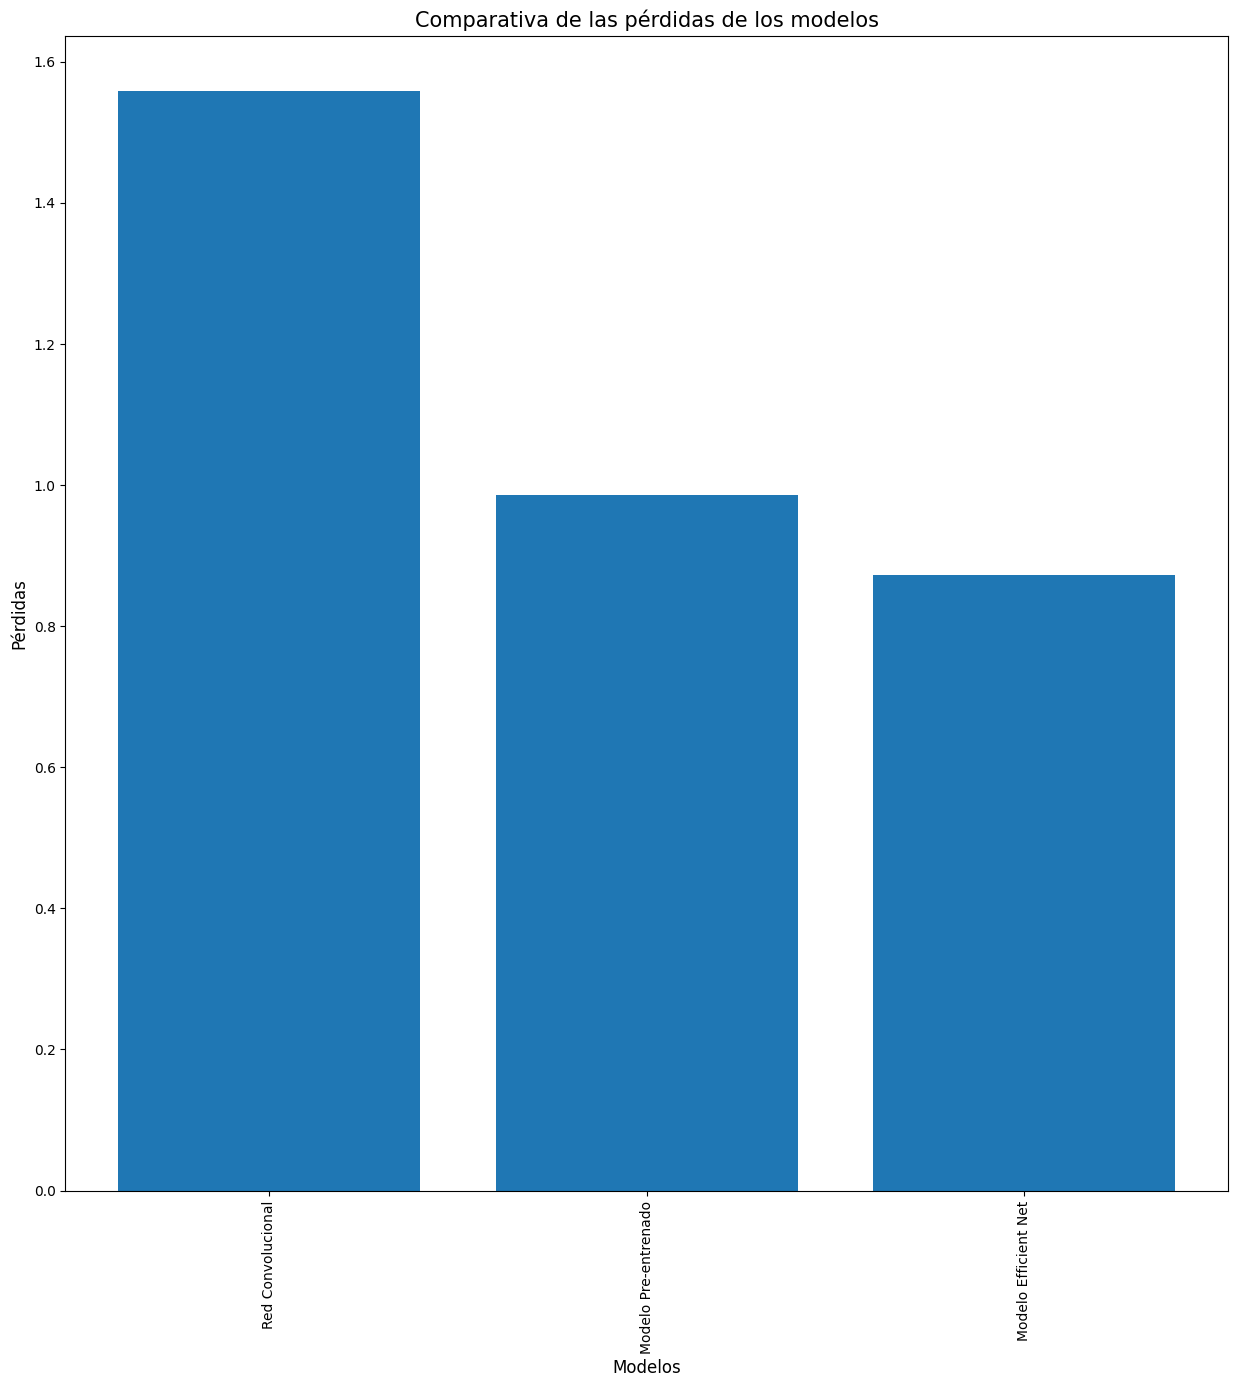

In [35]:
perdidas = [loss_redConv,loss_pre,loss_eff]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Efficient Net']
plt.figure(figsize=(15,15))
plt.bar(modelos,perdidas)
plt.xticks(rotation=90)
plt.xlabel('Modelos',fontsize=12)
plt.ylabel('Pérdidas',fontsize=12)
plt.title('Comparativa de las pérdidas de los modelos',fontsize=15)
plt.show()

## 8. Selección del mejor modelo